In [1]:
from importlib import reload
from astropy import units as u
from astropy import constants as const
# from astropy.modeling.models import BlackBody
# from astropy.units.equivalencies import spectral

import math

import numpy as np
import matplotlib.pyplot as plt
import pandas
from scipy.interpolate import UnivariateSpline

# from scipy.special import expn
# from scipy.integrate import simpson

from src import astro530
from src import N_integrator

In [30]:
myplot_specs = {
    'font.size' : 15
}

plt.rcParams.update(myplot_specs)

In [3]:
saha_LTE = astro530.saha_LTE

In [4]:
def k_Hbf(T = 5000,wavelength = 1000,nmax = 100):    
    
    a0 = 1.0443e-26
    
    R=1.09678e-3
    
    if (wavelength*u.s).unit == u.s:
        pass
    else:
        wavelength = (wavelength.to(u.angstrom)).value
        T = (T.to(u.K)).value
    K=0
    for n in range(1,nmax+1):
        #print(n)
        lmax = n**2/R
        
        chi = 13.6*(1-1/n**2)
        gbf = 1.-0.3456/(wavelength*R)**(1/3) * (wavelength*R/n**2 - 1/2)
        
        try:
            for i,l in enumerate(wavelength):
                if l > lmax: gbf[i] = 0
        except:
            if lmax < wavelength: gbf = 0
        
        K+= (wavelength/n)**3*gbf*10**(-5040/T * chi)
    K *= a0
    
    return K*u.cm**2

def k_Hff(T = 5000,wavelength = 1000):
    a0 = 1.0443e-26
    
    R=1.09678e-3
    
    if (wavelength*u.s).unit == u.s:
        pass
    else:
        wavelength = (wavelength.to(u.angstrom)).value
        T = (T.to(u.K)).value
        
    theta = 5040/T
    loge = 0.43429    
    I = ((const.h*const.c*const.Ryd).to(u.eV)).value    
    chi = 1.2398e4 / wavelength    
    gff = 1+ 0.3456/(wavelength*R)**(1/3) * (loge/(theta*chi)+1/2)
    
    K = a0*wavelength**3*gff*loge/(2*theta*I)*10**(-theta*I)
    
    return K*u.cm**2

def k_Hnbf(Pe,T = 5000,wavelength = 1000):
    if (wavelength*u.s).unit == u.s:
        pass
    else:
        wavelength = (wavelength.to(u.angstrom)).value
        T = (T.to(u.K)).value
        (Pe.to(u.dyne*u.cm**-2)).value
    
    a0 = 0.1199654
    a1 = -1.18267e-6
    a2 = 2.64243e-7
    a3 = -4.40524e-11
    a4 = 3.23992e-15
    a5 = -1.39568e-19
    a6 = 2.78701e-24
    
    abf = (a0+a1*wavelength+a2*wavelength**2+a3*wavelength**3+a4*wavelength**4+
           a5*wavelength**5+a6*wavelength**6)*10**-17
    
    theta = 5040/T
    
    try:
        zeroed = False
        for i,a in enumerate(abf):
            if a <= 0 or zeroed:
                abf[i] = 0
                zeroed = True
    except:
        if abf <= 0 or zeroed:
            abf = 0
            zeroed = True
    
    K = 4.158e-10*abf*Pe*theta**(5/2) * 10**(0.754*theta)
    
    return K*u.cm**2

def k_Hnff(Pe,T = 5000,wavelength = 9000):
    if (wavelength*u.s).unit == u.s:
        pass
    else:
        wavelength = (wavelength.to(u.angstrom)).value
        T = (T.to(u.K)).value
        Pe = (Pe.to(u.dyne*u.cm**-2)).value
    
        
    logl = np.log10(wavelength)
    logth = np.log10(5040/T)
        
    f0 = -2.2763 - 1.6850*logl + 0.76661*logl**2-0.053346*logl**3
    f1 = 15.2827-9.2846*logl+1.99381*logl**2-0.142631*logl**3
    f2 = -197.789+190.266*logl-67.9775*logl**2+10.6913*logl**3-0.625151*logl**4
    
    K = 1e-26*Pe*10**(f0+f1*logth+f2*logth**2)
    
    return K*u.cm**2

In [5]:
1/(1+saha_LTE("H",temp=7512*u.K)/500)

   Z Element     mu       1ion
0  1       H  1.008  13.598434


0.9975589822021258

In [6]:
T_arr = np.linspace(5000,12000,200)
y = 1/(1+saha_LTE("H",temp=T_arr*u.K)/500)

   Z Element     mu       1ion
0  1       H  1.008  13.598434


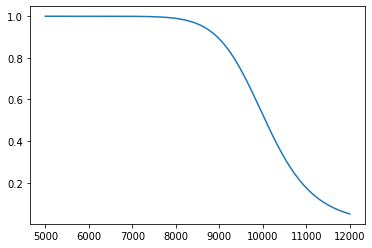

In [7]:
plt.plot(T_arr,y)

In [8]:
def k_total(Pe=10*u.dyne/u.cm**2,T = 5000*u.K,wavelength = 9000*u.angstrom,**kwargs):
    if (wavelength*u.s).unit == u.s:
        pass
    else:
        wavelength = (wavelength.to(u.angstrom)).value
        T = (T.to(u.K)).value
        Pe = (Pe.to(u.dyne*u.cm**-2)).value
        
    KHbf = k_Hbf(T=T,wavelength=wavelength,**kwargs)
    KHff = k_Hff(T=T,wavelength=wavelength)
    KHnbf = k_Hnbf(Pe,T=T,wavelength=wavelength)
    KHnff = k_Hnff(Pe,T=T,wavelength=wavelength)
    
    chi = 1.2398e4/wavelength
    theta = 5040/T
    
    phi = saha_LTE("H",temp=T)
    
    Kt = ((KHbf+KHff+KHnbf)*(1-10**(-chi*theta))+KHnff)*1/(1+phi/Pe)
    
    return Kt

In [9]:
lb_arr = np.linspace(100,10000,1000)
T= 7715*u.K
Pe = 10**2.5
#T_arr = np.array()
KHbf = k_Hbf(T=T.value,wavelength=lb_arr,nmax = 2)
Kt = k_total(Pe=Pe,T=T.value,wavelength=lb_arr)

   Z Element     mu       1ion
0  1       H  1.008  13.598434


In [10]:
k_Hbf(T=T.value,wavelength=lb_arr,nmax = 2)

<Quantity [1.33859458e-20, 1.75463656e-20, 2.24653035e-20, 2.81997419e-20,
           3.48055639e-20, 4.23376030e-20, 5.08496869e-20, 6.03946745e-20,
           7.10244899e-20, 8.27901520e-20, 9.57418009e-20, 1.09928723e-19,
           1.25399370e-19, 1.42201385e-19, 1.60381614e-19, 1.79986128e-19,
           2.01060236e-19, 2.23648500e-19, 2.47794752e-19, 2.73542102e-19,
           3.00932952e-19, 3.30009009e-19, 3.60811294e-19, 3.93380151e-19,
           4.27755259e-19, 4.63975640e-19, 5.02079668e-19, 5.42105076e-19,
           5.84088965e-19, 6.28067812e-19, 6.74077474e-19, 7.22153200e-19,
           7.72329633e-19, 8.24640820e-19, 8.79120213e-19, 9.35800682e-19,
           9.94714514e-19, 1.05589342e-18, 1.11936855e-18, 1.18517047e-18,
           1.25332921e-18, 1.32387423e-18, 1.39683445e-18, 1.47223823e-18,
           1.55011339e-18, 1.63048723e-18, 1.71338651e-18, 1.79883744e-18,
           1.88686573e-18, 1.97749655e-18, 2.07075457e-18, 2.16666393e-18,
           2.26524827e-18

In [11]:
n = 2
R=1.09678e-3
wavelength = lb_arr#912
T=7715

chi = 13.6*(1-1/n**2)
gbf = 1-0.3456/(wavelength*R)**(1/3) * (wavelength*R/n**2 - 1/2)

#print(0.3456/(wavelength*R)**(1/3) * (wavelength*R/n**2 - 1/2))
#print(10**(-5040/T * chi))

In [12]:
def abf(wavelength,n):
    a0 = 1.0443e-26
    R = ((const.Ryd).to(u.angstrom**-1)).value
    gbf = 1-0.3456/(wavelength*R)**(1/3) * (wavelength*R/n**2 - 1/2)
    
    lmax = n**2/R
    
    for i,l in enumerate(wavelength):
        if l>lmax: gbf[i] = 0
    
    return a0 * gbf * wavelength**3/n**5

In [13]:
def anbf(wavelength):
    a0 = 0.1199654
    a1 = -1.18267e-6
    a2 = 2.64243e-7
    a3 = -4.40524e-11
    a4 = 3.23992e-15
    a5 = -1.39568e-19
    a6 = 2.78701e-24
    
    abf = (a0+a1*wavelength+a2*wavelength**2+a3*wavelength**3+a4*wavelength**4+
           a5*wavelength**5+a6*wavelength**6)*10**-17
    return abf

(0.001, 10)

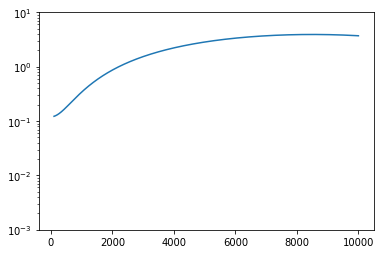

In [14]:
y = anbf(lb_arr)
plt.plot(lb_arr,y*10**17)
plt.yscale('log')
plt.ylim([0.001,10])

In [15]:
abf1 = abf(lb_arr,1)
abf2 = abf(lb_arr,2)
abf3 = abf(lb_arr,3)

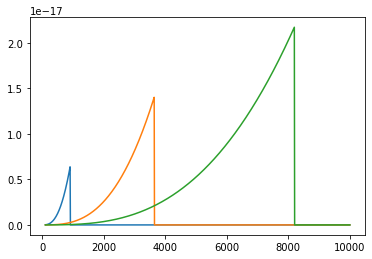

In [16]:
plt.plot(lb_arr,abf1)
plt.plot(lb_arr,abf2)
plt.plot(lb_arr,abf3)

In [28]:
lb_arr = np.linspace(3000,20000,1000)
T= 5143*u.K
Pe = 10**1.08
#T_arr = np.array()
KHbf = k_Hbf(T=T.value,wavelength=lb_arr)
KHff = k_Hff(T=T.value,wavelength=lb_arr)
KHnbf = k_Hnbf(Pe=Pe,T=T.value,wavelength=lb_arr)
KHnff = k_Hnff(Pe=Pe,T=T.value,wavelength=lb_arr)
Kt = k_total(Pe=Pe,T=T.value,wavelength=lb_arr)

   Z Element     mu       1ion
0  1       H  1.008  13.598434


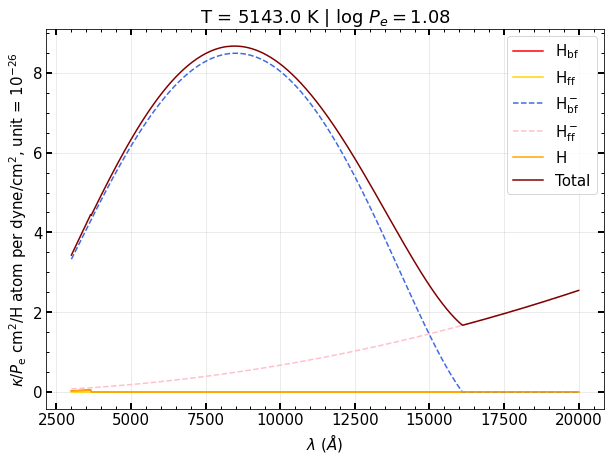

In [31]:
fig, ax = plt.subplots(figsize = (10,7),nrows=1, ncols=1)
    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

#ax.set_ylim([-0.2,5.8])

ax.plot(lb_arr,KHbf*10**26/Pe, label = r"H$_{\mathrm{bf}}$",c="red")
ax.plot(lb_arr,KHff*10**26/Pe, label = r"H$_{\mathrm{ff}}$",c="gold")
ax.plot(lb_arr,KHnbf*10**26/Pe, label = r"H$^-_{\mathrm{bf}}$",ls="--",c="royalblue")
ax.plot(lb_arr,KHnff*10**26/Pe, label = r"H$^-_{\mathrm{ff}}$",ls="--",c="pink")
ax.plot(lb_arr,(KHbf+KHff)*10**26/Pe, label = r"H",c="orange")

ax.plot(lb_arr,Kt*10**26/Pe, label = "Total",c="maroon")

title = "T = "+str(T)+r" | log $P_e=$"+str(np.log10(Pe))

ax.set_title(title)

ax.set_ylabel(r"$\kappa/P_\mathrm{e}$ cm$^2$/H atom per dyne/cm$^2$, unit = $10^{-26}$")
ax.set_xlabel(r"$\lambda~(\AA)$")

ax.legend()

   Z Element     mu       1ion
0  1       H  1.008  13.598434


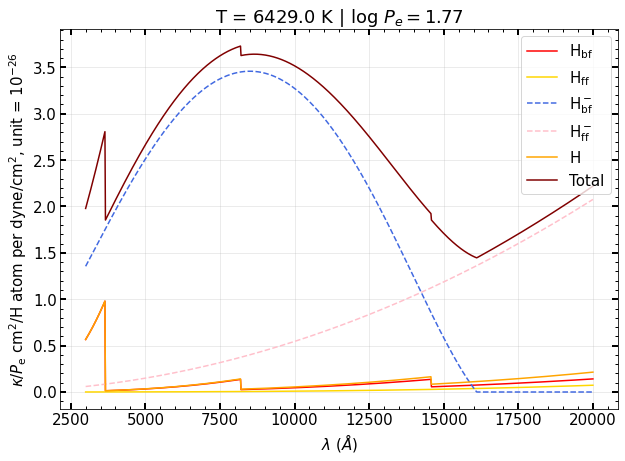

In [32]:
T= 6429*u.K
Pe = 10**1.77

#T_arr = np.array()
KHbf = k_Hbf(T=T.value,wavelength=lb_arr)
KHff = k_Hff(T=T.value,wavelength=lb_arr)
KHnbf = k_Hnbf(Pe=Pe,T=T.value,wavelength=lb_arr)
KHnff = k_Hnff(Pe=Pe,T=T.value,wavelength=lb_arr)
Kt = k_total(Pe=Pe,T=T.value,wavelength=lb_arr)

fig, ax = plt.subplots(figsize = (10,7),nrows=1, ncols=1)
    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

#ax.set_ylim([-0.2,5.8])

ax.plot(lb_arr,KHbf*10**26/Pe, label = r"H$_{\mathrm{bf}}$",c="red")
ax.plot(lb_arr,KHff*10**26/Pe, label = r"H$_{\mathrm{ff}}$",c="gold")
ax.plot(lb_arr,KHnbf*10**26/Pe, label = r"H$^-_{\mathrm{bf}}$",ls="--",c="royalblue")
ax.plot(lb_arr,KHnff*10**26/Pe, label = r"H$^-_{\mathrm{ff}}$",ls="--",c="pink")
ax.plot(lb_arr,(KHbf+KHff)*10**26/Pe, label = r"H",c="orange")

ax.plot(lb_arr,Kt*10**26/Pe, label = "Total",c="maroon")

title = "T = "+str(T)+r" | log $P_e=$"+str(np.log10(Pe))

ax.set_title(title)

ax.set_ylabel(r"$\kappa/P_\mathrm{e}$ cm$^2$/H atom per dyne/cm$^2$, unit = $10^{-26}$")
ax.set_xlabel(r"$\lambda~(\AA)$")

ax.legend()

output_file = "plots/15b_8_5b.pdf"

fig.savefig(output_file,bbox_inches='tight')

   Z Element     mu       1ion
0  1       H  1.008  13.598434


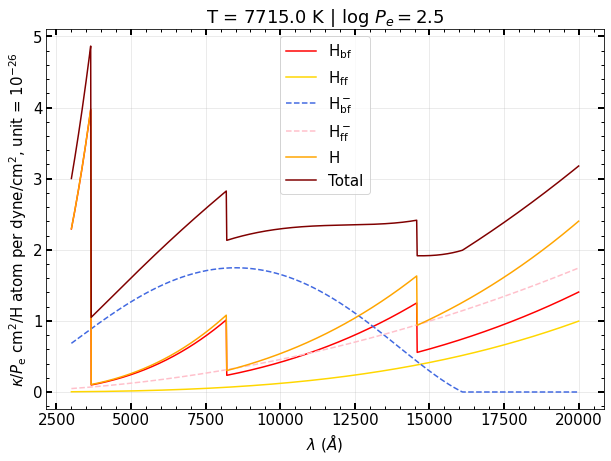

In [33]:
T= 7715*u.K
Pe = 10**2.5

#T_arr = np.array()
KHbf = k_Hbf(T=T.value,wavelength=lb_arr)
KHff = k_Hff(T=T.value,wavelength=lb_arr)
KHnbf = k_Hnbf(Pe=Pe,T=T.value,wavelength=lb_arr)
KHnff = k_Hnff(Pe=Pe,T=T.value,wavelength=lb_arr)
Kt = k_total(Pe=Pe,T=T.value,wavelength=lb_arr)

fig, ax = plt.subplots(figsize = (10,7),nrows=1, ncols=1)
    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

#ax.set_ylim([-0.2,5.8])

ax.plot(lb_arr,KHbf*10**26/Pe, label = r"H$_{\mathrm{bf}}$",c="red")
ax.plot(lb_arr,KHff*10**26/Pe, label = r"H$_{\mathrm{ff}}$",c="gold")
ax.plot(lb_arr,KHnbf*10**26/Pe, label = r"H$^-_{\mathrm{bf}}$",ls="--",c="royalblue")
ax.plot(lb_arr,KHnff*10**26/Pe, label = r"H$^-_{\mathrm{ff}}$",ls="--",c="pink")
ax.plot(lb_arr,(KHbf+KHff)*10**26/Pe, label = r"H",c="orange")

ax.plot(lb_arr,Kt*10**26/Pe, label = "Total",c="maroon")

title = "T = "+str(T)+r" | log $P_e=$"+str(np.log10(Pe))

ax.set_title(title)

ax.set_ylabel(r"$\kappa/P_\mathrm{e}$ cm$^2$/H atom per dyne/cm$^2$, unit = $10^{-26}$")
ax.set_xlabel(r"$\lambda~(\AA)$")

ax.legend()

output_file = "plots/15b_8_5c.pdf"

fig.savefig(output_file,bbox_inches='tight')

   Z Element     mu       1ion
0  1       H  1.008  13.598434


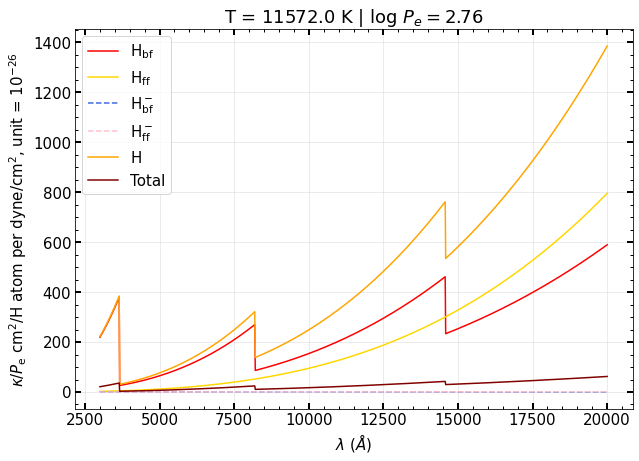

In [34]:
T= 11572*u.K
Pe = 10**2.76

#T_arr = np.array()
KHbf = k_Hbf(T=T.value,wavelength=lb_arr)
KHff = k_Hff(T=T.value,wavelength=lb_arr)
KHnbf = k_Hnbf(Pe=Pe,T=T.value,wavelength=lb_arr)
KHnff = k_Hnff(Pe=Pe,T=T.value,wavelength=lb_arr)
Kt = k_total(Pe=Pe,T=T.value,wavelength=lb_arr)

fig, ax = plt.subplots(figsize = (10,7),nrows=1, ncols=1)
    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

#ax.set_ylim([-0.2,5.8])

ax.plot(lb_arr,KHbf*10**26/Pe, label = r"H$_{\mathrm{bf}}$",c="red")
ax.plot(lb_arr,KHff*10**26/Pe, label = r"H$_{\mathrm{ff}}$",c="gold")
ax.plot(lb_arr,KHnbf*10**26/Pe, label = r"H$^-_{\mathrm{bf}}$",ls="--",c="royalblue")
ax.plot(lb_arr,KHnff*10**26/Pe, label = r"H$^-_{\mathrm{ff}}$",ls="--",c="pink")
ax.plot(lb_arr,(KHbf+KHff)*10**26/Pe, label = r"H",c="orange")

ax.plot(lb_arr,Kt*10**26/Pe, label = "Total",c="maroon")

title = "T = "+str(T)+r" | log $P_e=$"+str(np.log10(Pe))

ax.set_title(title)

ax.set_ylabel(r"$\kappa/P_\mathrm{e}$ cm$^2$/H atom per dyne/cm$^2$, unit = $10^{-26}$")
ax.set_xlabel(r"$\lambda~(\AA)$")

ax.legend()

output_file = "plots/15b_8_5d.pdf"

fig.savefig(output_file,bbox_inches='tight')

In [35]:
print(const.Ryd)
print((2*np.pi**2*const.m_e*(const.e.esu)**4/(const.h**3*const.c)).to(1/u.m))

  Name   = Rydberg constant
  Value  = 10973731.56816
  Uncertainty  = 2.1e-05
  Unit  = 1 / m
  Reference = CODATA 2018
10973731.556123957 1 / m


In [36]:
print(const.e.emu)

  Name   = Electron charge
  Value  = 1.6021766339999998e-20
  Uncertainty  = 0.0
  Unit  = abC
  Reference = CODATA 2018


In [37]:
lam = 5000
T = 11572
spec_em_fac = 1-10**(-1.2398e4/lam*5040/T)
print(spec_em_fac)

0.9168140893400311


In [25]:
((const.Ryd*(1/4))**-1).to(u.angstrom)

<Quantity 3645.06820233 Angstrom>

In [26]:
I = ((const.h*const.c*const.Ryd).to(u.eV)).value 

In [27]:
I

13.605693122994234